In [1]:
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

In [2]:
#NEW DATA TEST
caiso=pd.read_csv("/Users/john_schafer/Downloads/CE291/CAISO_zone_1_.csv")

In [3]:
#Transform Data to our format
caiso['time'] = pd.to_datetime(caiso['time'])
caiso.set_index('time', inplace=True)

# Function to reshape the data
def reshape_data(df, column):
    # Resample data to daily frequency, and apply list to convert each day's data into a list
    daily_data = df[column].resample('D').apply(list)
    # Convert lists to a DataFrame, which inherently transposes the list to columns
    return pd.DataFrame(daily_data.tolist(), index=daily_data.index)

# Creating each DataFrame
demand_df = reshape_data(caiso, 'load_power')
solar_df = reshape_data(caiso, 'solar_power')
wind_df = reshape_data(caiso, 'wind_power')

def rename_columns(df):
    num_minutes = df.shape[1]
    time_labels = [str(pd.Timedelta(minutes=i)) for i in range(num_minutes)]
    df.columns = time_labels
    return df

demand_df = rename_columns(demand_df)
solar_df = rename_columns(solar_df)
wind_df = rename_columns(wind_df)

In [4]:

#Scaling 
# if power is normalized to 1, PEV dynamics in environment are run in kw
#max power of single Ev = 11 kw 
#max power of representative small microgrid of 5,000 people ~ 3.5 megawatts=3,500 kw
#multiply vby 3500 to get representative 
demand_caiso = np.array(demand_df)
solar_caiso = np.array(solar_df)*3 
wind_caiso = np.array(wind_df)*4 
net_caiso=demand_caiso-solar_caiso-wind_caiso

average_demand_per_minute = np.nanmean(demand_caiso, axis=0)
average_solar_per_minute = np.nanmean(solar_caiso, axis=0)
average_wind_per_minute = np.nanmean(wind_caiso, axis=0)

average_net_per_minute=average_demand_per_minute-average_solar_per_minute-average_wind_per_minute

In [5]:
#Sample only every ten minutes
average_demand_10min= average_demand_per_minute[::10]
average_solar_10min= average_solar_per_minute[::10]
average_wind_10min= average_wind_per_minute[::10]

average_net_10min=average_demand_10min-average_solar_10min-average_wind_10min

average_demand_10min= average_demand_10min.reshape(144,1).T
average_solar_10min=average_solar_10min.reshape(144,1).T
average_wind_10min=average_wind_10min.reshape(144,1).T

In [6]:
from DQL_SOFT import DQNAgent
from env_rnn import GridEnvironment

In [9]:
#Testing Max Entropy Technique
import time
timestep_length=(10/60) #in hours
N=800
sequence_length=12 #In timesteps aka minutes
state_deque = deque(maxlen=sequence_length)

day_index=0
# Initialize DQN agent
agent = DQNAgent(state_size=3, action_size=21, sequence_length=sequence_length)

episode_durations = []

for episode in range(100):  # Loop over 3 episodes of same "average" day
    # Initialize environment for the current day
    start_time = time.time()
    env = GridEnvironment(N, average_demand_10min, average_solar_10min, average_wind_10min, day_index, timestep_length)
    
    total_reward = 0
    T = 144  # Assume T timesteps in a day

    demand_profile = np.zeros(T)
    solar_profile = np.zeros(T)
    wind_profile = np.zeros(T)
    PEV_profile = np.zeros(T)

    for timestep in range(1, T+1):  # Loop through each timestep in the day
        normalized_timestep = np.array([timestep / T])   # T is the total number of timesteps in a day

        current_demand, current_solar, current_wind, current_SoC = env.get_state()
        current_P_EV=env.P_EV
        current_state=np.concatenate([np.array([current_demand, current_solar, current_wind])])#, np.array(current_P_EV), normalized_timestep, current_SoC])

        state_deque.append(current_state)
        state_history = np.array(state_deque)

        if len(state_deque) < sequence_length:
            continue  # Wait until deque is full before starting training
        
        action = agent.act(state_history)  # Decide action based on current state
        # Execute action in the environment and observe the next state, reward, and done flag
        reward, done, next_demand, next_solar, next_wind, next_P_EV, next_SoC = env.step(action)

        # Update profiles for plotting
        demand_profile[timestep - 1] = next_demand
        solar_profile[timestep - 1] = next_solar
        wind_profile[timestep - 1] = next_wind
        PEV_profile[timestep - 1] = np.sum(next_P_EV)
        
        normalized_next_timestep = np.array([(timestep+1) / T])
        # Construct the new state from the separated components
        next_state = np.concatenate([np.array([next_demand, next_solar, next_wind])])#, np.array(next_P_EV), normalized_next_timestep, next_SoC])
        
        # Directly learn from this transition without using replay
        agent.learn(state_history, action, reward, next_state, done)

        # Update state and total_reward
        #state = next_state why did I have this?
        total_reward += reward
        

        if done:
            # Handle episode completion, if applicable
            break

    print(f"Total reward for episode {episode}: {total_reward}")
    agent.epsilon=max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay) 
    episode_durations.append(time.time() - start_time)
print("Individual episode durations:", episode_durations)


Total reward for episode 0: -143.40773121759253
Total reward for episode 1: -144.32348218680153
Total reward for episode 2: -129.42897376445478
Total reward for episode 3: -118.42128436469652
Total reward for episode 4: -127.34050267520811
Total reward for episode 5: -126.37630156216974
Total reward for episode 6: -116.88596198417879
Total reward for episode 7: -115.41566703476106
Total reward for episode 8: -109.9061596842136
Total reward for episode 9: -121.28252313117376
Total reward for episode 10: -114.09201273418638
Total reward for episode 11: -111.66211816155867
Total reward for episode 12: -110.74838631009388
Total reward for episode 13: -109.2064922679744
Total reward for episode 14: -100.74266703147043
Total reward for episode 15: -89.86557032951173
Total reward for episode 16: -110.06681502521326
Total reward for episode 17: -106.84958850809952
Total reward for episode 18: -111.42467568464753
Total reward for episode 19: -111.29931503192519
Total reward for episode 20: -116

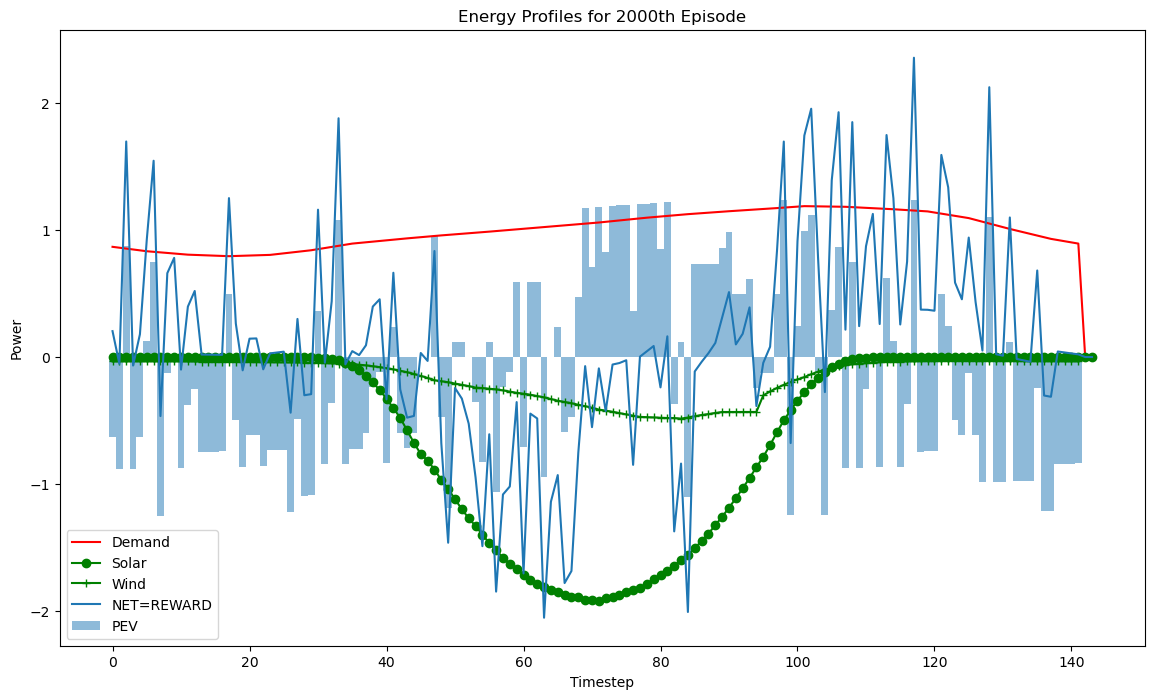

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(demand_profile, label='Demand', color="red")
plt.plot(-1*solar_profile, label='Solar', color='green', marker='o')
plt.plot(-1*wind_profile, label='Wind', color='green', marker='+')

plt.plot(demand_profile+PEV_profile -solar_profile- wind_profile, label='NET=REWARD')

# Plot the PEV_profile as a bar graph
timesteps = np.arange(len(PEV_profile))  
plt.bar(timesteps, PEV_profile, width=1.0, label='PEV', alpha=0.5)  



plt.legend()
plt.title('Energy Profiles for 2000th Episode')
plt.xlabel('Timestep')
plt.ylabel('Power')
#plt.savefig('2000_RNN_perc_action.png')
plt.show()